In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
import string
from textblob import TextBlob


In [90]:
data = pd.read_csv('datasets/customer_support_with_sentiment.csv')

In [91]:
data

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,sentiment_polarity,sentiment
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN,0.000000e+00,neutral
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN,1.305556e-01,positive
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,2.479167e-01,positive
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,2.500000e-01,positive
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,-7.930164e-18,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,8465,David Todd,adam28@example.net,22,Female,LG OLED,2021-12-08,Product inquiry,Installation support,My {product_purchased} is making strange noise...,Open,NaN,Low,Phone,NaN,NaN,NaN,-1.666667e-02,neutral
8465,8466,Lori Davis,russell68@example.com,27,Female,Bose SoundLink Speaker,2020-02-22,Technical issue,Refund request,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Email,NaN,NaN,NaN,1.305556e-01,positive
8466,8467,Michelle Kelley,ashley83@example.org,57,Female,GoPro Action Camera,2021-08-17,Technical issue,Account access,I'm having an issue with the {product_purchase...,Closed,Eight account century nature kitchen.,High,Social media,2023-06-01 09:44:22,2023-06-01 04:31:22,3.0,0.000000e+00,neutral
8467,8468,Steven Rodriguez,fpowell@example.org,54,Male,PlayStation,2021-10-16,Product inquiry,Payment issue,I'm having an issue with the {product_purchase...,Closed,We seat culture plan.,Medium,Email,2023-06-01 18:28:24,2023-06-01 05:32:24,3.0,8.333333e-02,neutral


Data Frame Creation

In [92]:
print(" Info :")
print(data.info())
print("\n Describe (numeric) :")
display(data.describe())
print("\n Missing values per column :")
display(data.isnull().sum())
print("\n Sentiment value counts:")
print(data['sentiment'].value_counts())

 Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 


,Ticket ID,Customer Age,Customer Satisfaction Rating,sentiment_polarity
count,8469.000000,8469.000000,2769.000000,8469.000000
mean,4235.000000,44.026804,2.991333,0.059683
std,2444.934048,15.296112,1.407016,0.201524
min,1.000000,18.000000,1.000000,-0.750000
25%,2118.000000,31.000000,2.000000,-0.033333
50%,4235.000000,44.000000,3.000000,0.020000
75%,6352.000000,57.000000,4.000000,0.161932
max,8469.000000,70.000000,5.000000,1.000000



 Missing values per column :


,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0



 Sentiment value counts:
sentiment
neutral     4266
positive    2949
negative    1254
Name: count, dtype: int64


In [93]:
print("Unique counts per column")
display(data.nunique().head())



numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns: ", numerical_cols)
print("Categorical columns: ", categorical_cols)

Unique counts per column


,0
Ticket ID,8469
Customer Name,8028
Customer Email,8320
Customer Age,53
Customer Gender,3


Numerical columns:  ['Ticket ID', 'Customer Age', 'Customer Satisfaction Rating', 'sentiment_polarity']
Categorical columns:  ['Customer Name', 'Customer Email', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'sentiment']


6. Removal of Unwanted data

In [94]:
drop_cols = ["Ticket ID","Customer Name","Customer Email","Date of Purchase","First Response Time","Time to Resolution",]

drop_cols = [c for c in drop_cols if c in data.columns]
data = data.drop(columns=drop_cols)

7. Feature Engineering

In [95]:
#combined text feature
data['text'] = (
    data['Ticket Subject'].fillna('') + " " +
    data['Ticket Description'].fillna('')
).astype(str)

In [96]:
#Handle missing numeric values
num_cols = ['Customer Age', 'Customer Satisfaction Rating','sentiment_polarity']
for col in num_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

In [97]:
# 4. Handle missing categorical values
cat_cols = ['Customer Gender', 'Product Purchased', 'Ticket Type','Ticket Status', 'Ticket Priority', 'Ticket Channel','Resolution']
for col in cat_cols:
    if col in data.columns:
        data[col] = data[col].fillna("Unknown")

In [98]:
data = data.dropna(subset=['sentiment'])
print("Shape after processing:", data.shape)
data.head()

Shape after processing: (8469, 14)


,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,Customer Satisfaction Rating,sentiment_polarity,sentiment,text
0,32,Other,GoPro Hero,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,Unknown,Critical,Social media,3.0,0.000000e+00,neutral,Product setup I'm having an issue with the {pr...
1,42,Female,LG Smart TV,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,Unknown,Critical,Chat,3.0,1.305556e-01,positive,Peripheral compatibility I'm having an issue w...
2,48,Other,Dell XPS,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,3.0,2.479167e-01,positive,Network problem I'm facing a problem with my {...
3,27,Female,Microsoft Office,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,3.0,2.500000e-01,positive,Account access I'm having an issue with the {p...
4,67,Female,Autodesk AutoCAD,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,1.0,-7.930164e-18,neutral,Data loss I'm having an issue with the {produc...


In [99]:
# 7.5 — Light text cleaning (lower, remove urls/emails/numbers/punct, collapse spaces)
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)      # remove urls
    s = re.sub(r'\S+@\S+', ' ', s)              # remove emails
    s = re.sub(r'\d+', ' ', s)                  # remove numbers
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

data['text_clean'] = data['text'].apply(clean_text)


In [100]:
# # 7.6 — Simple numeric text features: char length, word count, question flag
# data['text_len'] = data['text_clean'].apply(len)                     # number of characters
# data['word_count'] = data['text_clean'].apply(lambda x: len(x.split()) if x else 0)
# data['has_question'] = data['text'].apply(lambda x: 1 if '?' in str(x) else 0)


8.Outlier handling

In [101]:
# numeric_cols = ['Customer Age','text_len','word_count','polarity','subjectivity']
for col in num_cols:
    if col in data.columns:
        lower = data[col].quantile(0.01)
        upper = data[col].quantile(0.99)
        data[col] = data[col].clip(lower, upper)

data[num_cols].describe()


,Customer Age,Customer Satisfaction Rating,sentiment_polarity
count,8469.000000,8469.000000,8469.000000
mean,44.026804,2.997166,0.058493
std,15.296112,0.804446,0.196867
min,18.000000,1.000000,-0.500000
25%,31.000000,3.000000,-0.033333
50%,44.000000,3.000000,0.020000
75%,57.000000,3.000000,0.161932
max,70.000000,5.000000,0.500000


In [102]:
# Make sure we have a text column
data['text'] = (data['Ticket Subject'].fillna('') + " " +data['Ticket Description'].fillna(''))

# Binary target: positive vs not_positive
data['sentiment_bin'] = data['sentiment'].apply(lambda x: 'positive' if str(x).strip().lower() == 'positive' else 'not_positive')

print("\nBinary sentiment counts:")
print(data['sentiment_bin'].value_counts())


Binary sentiment counts:
sentiment_bin
not_positive    5520
positive        2949
Name: count, dtype: int64


In [103]:
# 3. DEFINE FEATURES
text_col = 'text'
cat_cols = ['Ticket Priority', 'Ticket Status', 'Ticket Type', 'Ticket Channel']
num_cols = ['Customer Satisfaction Rating','polarity','subjectivity','text_len','word_count']


In [104]:
#keep only rows where these columns exist
available_cat = [c for c in cat_cols if c in data.columns]
available_num = [c for c in num_cols if c in data.columns]

# Fill missing
data[available_cat] = data[available_cat].fillna("Unknown")
data[available_num] = data[available_num].fillna(data[available_num].median())

9. Filling Missing Values

In [105]:
# #Identify numerical & categorical columns
# numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# print("Numerical columns:", numerical_cols)
# print("Categorical columns:", categorical_cols)

# #Fill missing values in numerical columns with MEDIAN
# for col in numerical_cols:
#     if data[col].isnull().any():
#         data[col].fillna(data[col].median(), inplace=True)

# #Fill missing values in categorical columns with MODE
# for col in categorical_cols:
#     if data[col].isnull().any():
#         mode_value = data[col].mode().iloc[0] if not data[col].mode().empty else "Unknown"
#         data[col].fillna(mode_value, inplace=True)

# #Check final missing values
# print("\nMissing values after filling:")
# display(data.isnull().sum())


9. Encoding

In [106]:
print(data.columns.tolist())

['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'Customer Satisfaction Rating', 'sentiment_polarity', 'sentiment', 'text', 'text_clean', 'sentiment_bin']


In [107]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
#Used TF-IDF for text encoding

le = LabelEncoder()
y = le.fit_transform(data['sentiment'])

X = data['text']   # Ticket Subject + Ticket Description

tfidf = TfidfVectorizer(max_features=18000, ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(X)
print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

y = data['sentiment_bin']


Mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


10. EDA (Exploratory Data Analysis)

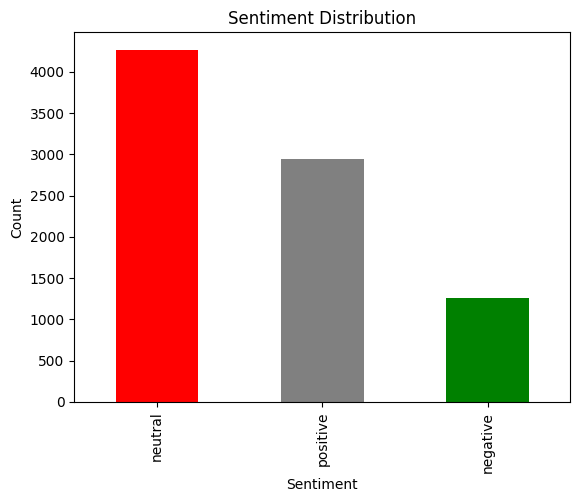

In [108]:
#Sentiment Distribution
data['sentiment'].value_counts().plot(kind='bar', color=['red','gray','green'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

<Figure size 800x500 with 0 Axes>

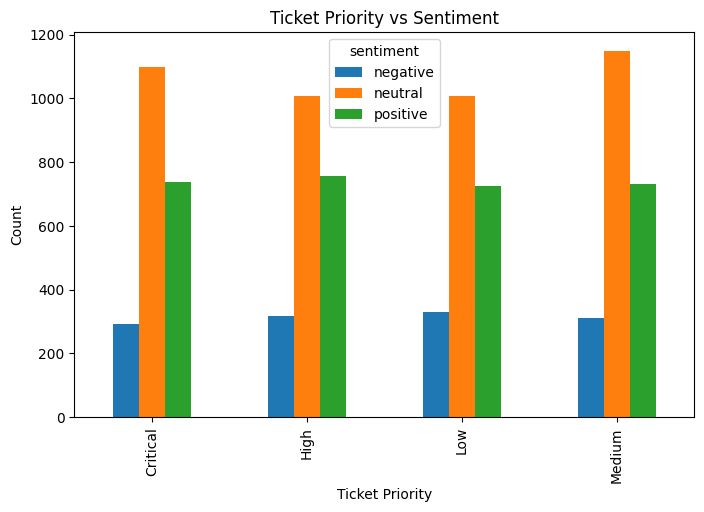

In [109]:
#Ticket Priority vs Sentiment
plt.figure(figsize=(8,5))
pd.crosstab(data['Ticket Priority'], data['sentiment']).plot(kind='bar', figsize=(8,5))
plt.title("Ticket Priority vs Sentiment")
plt.xlabel("Ticket Priority")
plt.ylabel("Count")
plt.show()

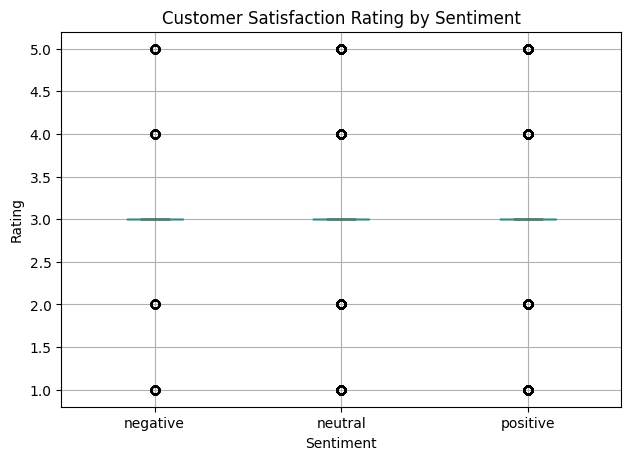

In [110]:
#Customer Satisfaction Rating vs Sentiment
if 'Customer Satisfaction Rating' in data.columns:
    data.boxplot(column='Customer Satisfaction Rating', by='sentiment', figsize=(7,5))
    plt.title("Customer Satisfaction Rating by Sentiment")
    plt.suptitle("")   # removes extra title
    plt.xlabel("Sentiment")
    plt.ylabel("Rating")
    plt.show()

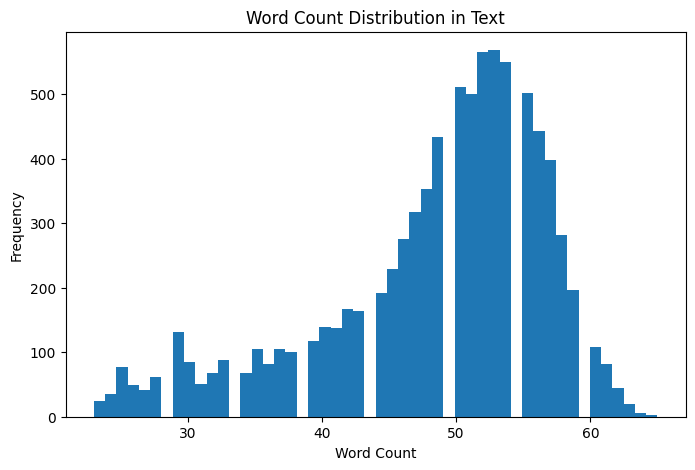

In [111]:
#Word Count Distribution
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
data['word_count'].plot(kind='hist', bins=50)
plt.title("Word Count Distribution in Text")
plt.xlabel("Word Count")
plt.show()

12. Decide X and Y,train test split

In [112]:
from textblob import TextBlob

data['polarity'] = data['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data['subjectivity'] = data['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

data['text_len'] = data['text'].apply(lambda x: len(str(x)))

data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))


In [113]:
feature_cols = [text_col] + cat_cols + num_cols
X = data[feature_cols]
y = data['sentiment_bin']

print("\nFinal feature columns:", feature_cols)
print("X shape:", X.shape, " | y shape:", y.shape)
print("X type:", type(X))


Final feature columns: ['text', 'Ticket Priority', 'Ticket Status', 'Ticket Type', 'Ticket Channel', 'Customer Satisfaction Rating', 'polarity', 'subjectivity', 'text_len', 'word_count']
X shape: (8469, 10)  | y shape: (8469,)
X type: <class 'pandas.core.frame.DataFrame'>


Train Test Split

In [114]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6775, 10)
X_test shape: (1694, 10)
y_train shape: (6775,)
y_test shape: (1694,)


PreProcessor

In [115]:
preprocess = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=8000,
            ngram_range=(1, 2),
            stop_words='english'
        ), text_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), available_cat),
        ('num', StandardScaler(), available_num)
    ]
)
#Used OneHotEncoder for categorical feature encoding
#StandardScaler for numeric feature scaling

6. LOGISTIC REGRESSION PIPELINE


In [116]:
from sklearn.utils import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights = dict(zip(np.unique(y), class_weights))
print(class_weights)
('model', LogisticRegression(
    class_weight=class_weights,
    C=2,
    max_iter=8000,
    n_jobs=-1
))


{'not_positive': np.float64(0.7671195652173913), 'positive': np.float64(1.435910478128179)}


('model',
 LogisticRegression(C=2,
                    class_weight={'not_positive': np.float64(0.7671195652173913),
                                  'positive': np.float64(1.435910478128179)},
                    max_iter=8000, n_jobs=-1))

In [137]:
clf = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=6000,
        C=0.4,
        solver='lbfgs',
        class_weight=class_weights,
        n_jobs=-1
    ))
])

In [138]:
#Model Fitting
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)
diff      = abs(train_acc - test_acc)

print("\n LOGISTIC REGRESSION RESULTS:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Diff          : {diff:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))



 LOGISTIC REGRESSION RESULTS:
Train Accuracy: 0.8706
Test Accuracy : 0.8495
Diff          : 0.0211

Classification Report:
               precision    recall  f1-score   support

not_positive       0.87      0.90      0.89      1104
    positive       0.80      0.76      0.78       590

    accuracy                           0.85      1694
   macro avg       0.84      0.83      0.83      1694
weighted avg       0.85      0.85      0.85      1694




===== RANDOM FOREST RESULTS =====
Train Accuracy: 0.8384
Test Accuracy : 0.8418
Diff          : 0.0034

Classification Report (Random Forest):
              precision    recall  f1-score   support

not_positive       0.84      0.93      0.88      1104
    positive       0.84      0.67      0.75       590

    accuracy                           0.84      1694
   macro avg       0.84      0.80      0.82      1694
weighted avg       0.84      0.84      0.84      1694



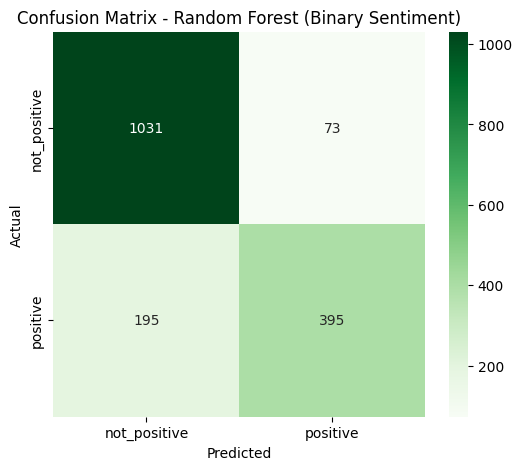

In [119]:
rf_clf = Pipeline([
    ('preprocess', preprocess),   # TF-IDF + OneHot + Scaling
    ('model', RandomForestClassifier(
        n_estimators=400,          # number of trees
        max_depth=16,              # limit tree depth -controls overfitting
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

# ---- Train ----
rf_clf.fit(X_train, y_train)

# ---- Predictions ----
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf  = rf_clf.predict(X_test)

# ---- Metrics ----
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf  = accuracy_score(y_test, y_test_pred_rf)
diff_rf      = abs(train_acc_rf - test_acc_rf)

print("\n===== RANDOM FOREST RESULTS =====")
print(f"Train Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy : {test_acc_rf:.4f}")
print(f"Diff          : {diff_rf:.4f}")

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_test_pred_rf))

# ---- Confusion Matrix ----
labels = ['not_positive', 'positive']
cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Binary Sentiment)")
plt.show()



===== KNN RESULTS =====
Train Accuracy: 1.0000
Test Accuracy : 0.6281
Diff          : 0.3719

Classification Report (KNN):
              precision    recall  f1-score   support

not_positive       0.68      0.82      0.74      1104
    positive       0.45      0.28      0.34       590

    accuracy                           0.63      1694
   macro avg       0.56      0.55      0.54      1694
weighted avg       0.60      0.63      0.60      1694



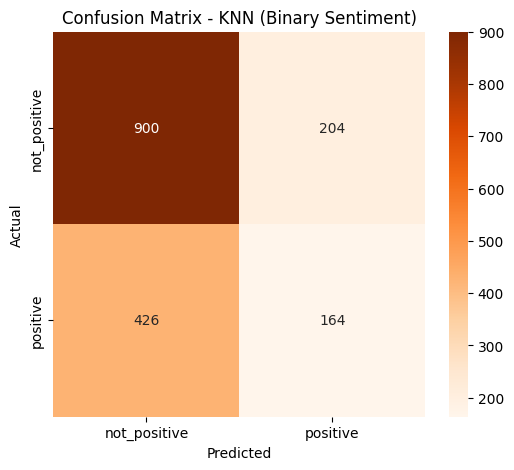

In [120]:
# ================================================
# K-NEAREST NEIGHBORS (KNN) CLASSIFIER
# ================================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

knn_clf = Pipeline([
    ('preprocess', preprocess),
    ('model', KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',   # closer neighbors count more
        n_jobs=-1
    ))
])

# Train
knn_clf.fit(X_train, y_train)

# Predict
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn  = knn_clf.predict(X_test)

# Metrics
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn  = accuracy_score(y_test, y_test_pred_knn)
diff_knn      = abs(train_acc_knn - test_acc_knn)

print("\n===== KNN RESULTS =====")
print(f"Train Accuracy: {train_acc_knn:.4f}")
print(f"Test Accuracy : {test_acc_knn:.4f}")
print(f"Diff          : {diff_knn:.4f}")
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_test_pred_knn))

# Confusion matrix
labels = ['not_positive', 'positive']
cm_knn = confusion_matrix(y_test, y_test_pred_knn, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN (Binary Sentiment)")
plt.show()



===== NAIVE BAYES RESULTS =====
Train Accuracy: 0.8397
Test Accuracy : 0.8400
Diff          : 0.0003

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

not_positive       0.84      0.94      0.88      1104
    positive       0.85      0.65      0.74       590

    accuracy                           0.84      1694
   macro avg       0.84      0.80      0.81      1694
weighted avg       0.84      0.84      0.83      1694



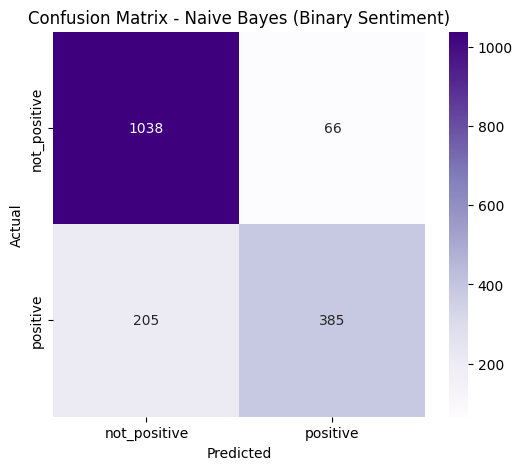

In [121]:
# ================================================
# NAIVE BAYES (MultinomialNB) CLASSIFIER
# ================================================
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# New preprocessor for NB: TF-IDF + OneHot + raw numeric (no StandardScaler)
preprocess_nb = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=6000,
            ngram_range=(1, 2),
            stop_words='english'
        ), text_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), available_cat),
        ('num', 'passthrough', available_num)   # keep non-negative numeric values
    ]
)

nb_clf = Pipeline([
    ('preprocess', preprocess_nb),
    ('model', MultinomialNB())
])

# Train
nb_clf.fit(X_train, y_train)

# Predict
y_train_pred_nb = nb_clf.predict(X_train)
y_test_pred_nb  = nb_clf.predict(X_test)

# Metrics
train_acc_nb = accuracy_score(y_train, y_train_pred_nb)
test_acc_nb  = accuracy_score(y_test, y_test_pred_nb)
diff_nb      = abs(train_acc_nb - test_acc_nb)

print("\n===== NAIVE BAYES RESULTS =====")
print(f"Train Accuracy: {train_acc_nb:.4f}")
print(f"Test Accuracy : {test_acc_nb:.4f}")
print(f"Diff          : {diff_nb:.4f}")
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_test_pred_nb))

# Confusion matrix
labels = ['not_positive', 'positive']
cm_nb = confusion_matrix(y_test, y_test_pred_nb, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes (Binary Sentiment)")
plt.show()


In [122]:


import numpy as np

y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred  = clf.predict(X_test)

# Convert test set into a DataFrame (to access text easily)
X_test_df = X_test.copy()
X_test_df['true_sentiment'] = y_test.values
X_test_df['predicted_sentiment'] = y_test_pred
X_test_df['positive_prob'] = y_test_proba

print("\nSAMPLE PREDICTIONS\n")

for i in range(5):
    text_sample = X_test_df[text_col].iloc[i][:250]  # show only first 250 chars
    true_val = X_test_df['true_sentiment'].iloc[i]
    pred_val = X_test_df['predicted_sentiment'].iloc[i]
    prob_val = X_test_df['positive_prob'].iloc[i]

    print("---------------------------------------------------")
    print(f"TEXT: {text_sample}")
    print(f"TRUE : {true_val}")
    print(f"PRED : {pred_val}")
    print(f"PROB : {prob_val:.4f}")
    print("---------------------------------------------------\n")



SAMPLE PREDICTIONS

---------------------------------------------------
TEXT: Payment issue I've recently set up my {product_purchased}, but it fails to connect to any available networks. What steps should I take to troubleshoot this issue?

How does the server detect a new product?

This might I've followed the troubleshootin
TRUE : not_positive
PRED : not_positive
PROB : 0.0191
---------------------------------------------------

---------------------------------------------------
TEXT: Installation support I'm having an issue with the {product_purchased}. Please assist.

I need to contact another person to buy this brand, but I already received this name. I've received the brand from a friend but this brand is not I've performed a 
TRUE : not_positive
PRED : not_positive
PROB : 0.2922
---------------------------------------------------

---------------------------------------------------
TEXT: Software bug I'm having an issue with the {product_purchased}. Please assist. Thanks. Tha

AUC Score: 0.924


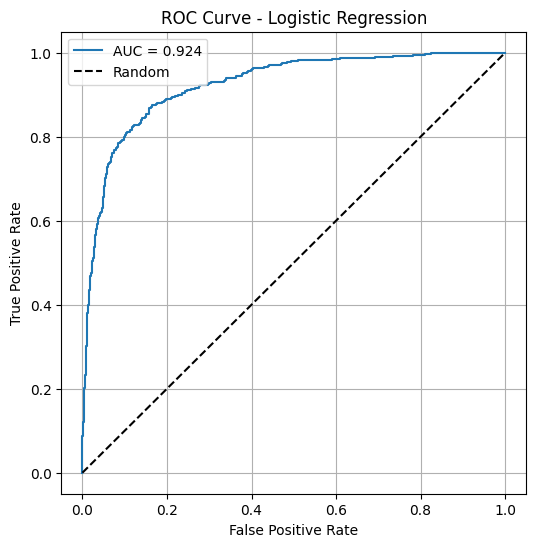

Best Threshold (TPR-FPR maximized): 0.395006196545585


In [123]:
# ROC - AUC CURVE
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for the positive class
y_test_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label='positive')

# Compute AUC
auc_score = roc_auc_score(y_test, y_test_proba)

print("AUC Score:", round(auc_score, 4))

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Find best threshold (threshold where TPR - FPR is maximum)
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]

print("Best Threshold (TPR-FPR maximized):", best_threshold)


In [124]:
!pip install transformers torch --quiet


In [125]:
import re

def detect_language(text):
    text = str(text)

    # Very rough heuristics just for demo
    # Devanagari range → Hindi
    if re.search(r'[\u0900-\u097F]', text):
        return "hi"

    # Some common Spanish words or characters
    spanish_keywords = ['hola', 'gracias', 'por favor', 'buenos', 'día', 'señor']
    if any(word in text.lower() for word in spanish_keywords):
        return "es"

    # default English
    return "en"

# Test:
print(detect_language("I am unhappy with your service"))
print(detect_language("Mujhe support chahiye, product kaam nahi kar raha"))
print(detect_language("Hola, tengo un problema con mi producto"))


en
en
es


In [126]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# XLM-RoBERTa multilingual sentiment model (3-class: neg/neu/pos)
xlm_model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

xlm_tokenizer = AutoTokenizer.from_pretrained(xlm_model_name)
xlm_model = AutoModelForSequenceClassification.from_pretrained(xlm_model_name)
xlm_model.eval()  # evaluation mode


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [127]:
import torch.nn.functional as F

label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

def predict_multilingual_sentiment(text):
    lang = detect_language(text)
    lang_tag = f"[LANG_{lang}] "
    input_text = lang_tag + str(text)

    # Tokenize
    encoded = xlm_tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = xlm_model(**encoded)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1).numpy()[0]  # [P(neg), P(neu), P(pos)]

    # Build nice result dict
    result = {
        "language_detected": lang,
        "text": text,
        "prob_negative": float(probs[0]),
        "prob_neutral": float(probs[1]),
        "prob_positive": float(probs[2]),
        "pred_label": label_mapping[int(np.argmax(probs))]
    }
    return result


In [128]:
examples = [
    "I am very happy with the support I received, thank you so much!",
    "Service bahut slow tha, mujhe bilkul pasand nahi aaya.",
    "Hola, el producto no funciona correctamente y necesito ayuda urgente.",
    "Overall the call was okay, nothing special but not too bad.",
    "Agent ne jaldi problem solve kar diya, I'm satisfied."
]

print("=========== CROSS-LINGUAL / CODE-MIXED SENTIMENT DEMO ===========\n")
for txt in examples:
    res = predict_multilingual_sentiment(txt)
    print("TEXT:", res["text"])
    print("LANG:", res["language_detected"])
    print("P(NEGATIVE):", f"{res['prob_negative']:.4f}")
    print("P(NEUTRAL) :", f"{res['prob_neutral']:.4f}")
    print("P(POSITIVE):", f"{res['prob_positive']:.4f}")
    print("PRED LABEL :", res["pred_label"])


=========== CROSS-LINGUAL / CODE-MIXED SENTIMENT DEMO ===========

TEXT: I am very happy with the support I received, thank you so much!
LANG: en
P(NEGATIVE): 0.0154
P(NEUTRAL) : 0.0519
P(POSITIVE): 0.9326
PRED LABEL : positive
TEXT: Service bahut slow tha, mujhe bilkul pasand nahi aaya.
LANG: en
P(NEGATIVE): 0.7211
P(NEUTRAL) : 0.2032
P(POSITIVE): 0.0757
PRED LABEL : negative
TEXT: Hola, el producto no funciona correctamente y necesito ayuda urgente.
LANG: es
P(NEGATIVE): 0.6556
P(NEUTRAL) : 0.3156
P(POSITIVE): 0.0288
PRED LABEL : negative
TEXT: Overall the call was okay, nothing special but not too bad.
LANG: en
P(NEGATIVE): 0.1832
P(NEUTRAL) : 0.3129
P(POSITIVE): 0.5039
PRED LABEL : positive
TEXT: Agent ne jaldi problem solve kar diya, I'm satisfied.
LANG: en
P(NEGATIVE): 0.0804
P(NEUTRAL) : 0.1868
P(POSITIVE): 0.7328
PRED LABEL : positive
